<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/19_2_%D0%9F%D0%B5%D1%80%D0%B5%D0%BD%D0%BE%D1%81_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B2_Keras_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Keras v3. Современные подходы к CV (компьютерное зрение)](https://colab.research.google.com/drive/16ks3VjO38c7N4kXUsrdzUbunJOxRu3Fq)
2. Перенос обучения в Keras 3.0
3. [Знакомство с KerasCV](https://colab.research.google.com/drive/1ZWfrEDQaQqDmVUF0yk7N4yoMHRkXf9K-)
4. [Домашняя работа](https://colab.research.google.com/drive/1ElbaB78l4c9BbIfHIgBMAzzr0-pBq4QO)

В данном уроке, мы с познакомимся еще с одной предобученной моделью компьютерного зрения, представленной в Keras - `EfficientNet`. С помощью этой модели мы научимся распознавать (точнее классифицировать) породы собак. Схема обучения, показанная в этом уроке, имеет огромную область применения. Вы всего лишь изменяете датасет и получаете новые модели для новых задач. Все ограниченно только вашей фантазией!

Приведем несколько примеров:
* распознавание сорняков для автоматического внесения пестицидов в почву;
* распознавание марки и модели автомобиля (часто используется на автоматических шлагбаумах для контроля номеров);
* распознавание целей беспилотниками;
* мобильные приложения для натуралистов и коллекционеров (поиск по изображению с камеры грибов, животных, растений, картин, предметов антиквариата и прочих вещей по каталогам);
* и многое другое.

И так приступим к созданию классификатора пород собак! Для этого сначала изучим модель `EfficientNet`.

## Перенос обучения на примере модели EfficientNet

### Что такое EfficientNet?

EfficientNet - это модель, которая была впервые представленная в 2019 году разработчиками и исследователями команды GoogleResearch Tan и Le. С оригинальной статьей можно ознакомиться здесь (https://arxiv.org/pdf/1905.11946.pdf). Это одна из наиболее эффективных моделей, т.к. требует наименьшего числа `FLOPS` (операций с плавающей запятой в секунду) на `Inference` (так называют режим "угадывания" или предсказания, обученной нейронной сети) по сравнению с аналогичными моделями, обученными на наборе данных `imagenet`.

Модель EfficientNet - это не одна модель, а целое семейство (от B0 до B7, так их назвали авторы), которые представляют собой хорошее сочетание эффективности и точности в различных масштабах.

Модель доступна на [GitHub](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet), где с ней можно подробно ознакомиться. Эти модели можно использовать путем обновления весов без изменения архитектуры модели в своей практике.

Если вам лень читать статью или ваш английский не позволяет, то **основные моменты, которые важно вынести из статьи**, следующие:
1. Используемый подход в моделировании архитектуры сети и подбора гиперпараметров авторы назвали "комплексное масштабирование".
2. Авторы изучали масштабирование моделей и балансирование между собой глубины и ширины (количества каналов) сети, а также разрешение изображений в сетке. Был предложен новый метод масштабирования, который равномерно масштабирует глубину/ширину/разрешение.
3. Комплексное масштабирование основано на фиксации производимые внутри сетки операции и меняются лишь глубина (количество повторений одних и тех же модулей) d, ширина (количество каналов в свёртках) w и разрешение r. Задача масштабирования формулируется как проблема оптимизации – хотим максимальную точность при заданных d, w, r при том, что не вылезаем за границу по памяти и по FLOPS (вычислений с плавающей запятой в секунду).
4. Авторы показывают эффективность масштабирования на MobileNet, ResNet, а также предлагают новую модель EfficientNets, масшабируя которую получили целую серию моделей.
5. Сравнения EfficientNets (с разными масштабами) и других популярных моделей компьютерного зрения, обученных на наборе данных ImageNet, показали его эффективность. Например, модель из прошлого урока  `Xception` была по оцениваемым метрикам на уровне `EfficientNet-B1`, при этом по числу параметров `EfficientNet-B1` была в 3 раза меньше, а значит и быстрее обучалась.
6. Важными параметрами в моделе являются ширина, глубина и разрешение. В Keras представлены 8 моделей с подобранными параметрами (от B0 до B7) в соответствии с формулой комплексного масштабирования. Хотя кажется логичным было бы дать возможность проектировщику самому задавать эти параметры, проводить ручную настройку.  
7. При увеличении разрешения изображения сети необходимо больше слоёв в глубину для увеличения рецептивного поля и больше каналов для того, чтобы ухватить все паттерны в изображении с более высоким разрешением.
8. В результате глубина, ширина и разрешение каждого варианта моделей EfficientNet подбираются вручную и, как доказано, дают хорошие результаты, хотя они могут значительно отличаться от формулы комплексного масштабирования.



Реализация `EfficientNet` от B0 до B7 поставляется вместе с Keras начиная с версии 2.3. Мы будем использовать базовую модель `EfficientNetB0`, обученную классифицировать 1000 классов изображений из набора данных ImageNet.

Эта модель принимает входные изображения формы `(224, 224, 3)`, и входные данные должны находиться в диапазоне `[0, 255]`. Слой нормализации уже включен в модель.

Для базовых моделей от B0 до B7 входные формы различны. Вот список входных форм, ожидаемых для каждой модели:

<table >
  <tr><th>Базовая модель</th><th>Разрешение<br>(размер изображения)</th></tr>
  <tr><td>EfficientNetB0</td><td align="center">224</td></tr>
  <tr><td>EfficientNetB1</td><td align="center">240</td></tr>
  <tr><td>EfficientNetB2</td><td align="center">260</td></tr>
  <tr><td>EfficientNetB3</td><td align="center">300</td></tr>
  <tr><td>EfficientNetB4</td><td align="center">380</td></tr>
  <tr><td>EfficientNetB5</td><td align="center">456</td></tr>
  <tr><td>EfficientNetB6</td><td align="center">528</td></tr>
  <tr><td>EfficientNetB7</td><td align="center">600</td></tr>
</table>

### Обновим версию Keras

Мы хотим работать с современными моделями и с помощью современных инструментов. Поэтому обновим Keras до версии 3!

Текущая версия:

In [ ]:
import keras
print(keras.__version__)

2.15.0


Обновляем:

In [ ]:
!pip install --upgrade keras==3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


**ВАЖНО**. Не забываем перезапустить сессию, а также переключиться на графический процессор.

Проверяем версию:

In [ ]:
import keras
print(keras.__version__)

3.0.0


### Импортируем библиотеки

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetB0

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

### Набор данных

Для обучения мы будем использовать набор данных [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html), который содержит изображения 120 пород собак со всего мира. Этот набор данных был создан с использованием изображений и аннотаций из ImageNet для задачи детальной категоризации изображений. Набор содержит 20 580 изображений собак, поделенных на 120 папок, каждая папка - отдельный класс (порода).



In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2024-02-16 22:29:03--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  21.1MB/s    in 37s     

2024-02-16 22:29:41 (20.1 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
# Разархивируем датасета во временную папку 'temp'
!unzip -qo "stanford_dogs" -d ./dataset

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

### Отфильтруем поврежденные изображения

Используем знакомый нам алгоритм из урока 19.1:

In [ ]:
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


### Генерируем датасет

*Сгенерируем* датасет, используя рекомендуемый в документации метод `image_dataset_from_directory`:

In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.


Определим метки датасета:

In [ ]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

Возьмем первый батч обучающей выборки и посмотрим на первые 16 картинок:

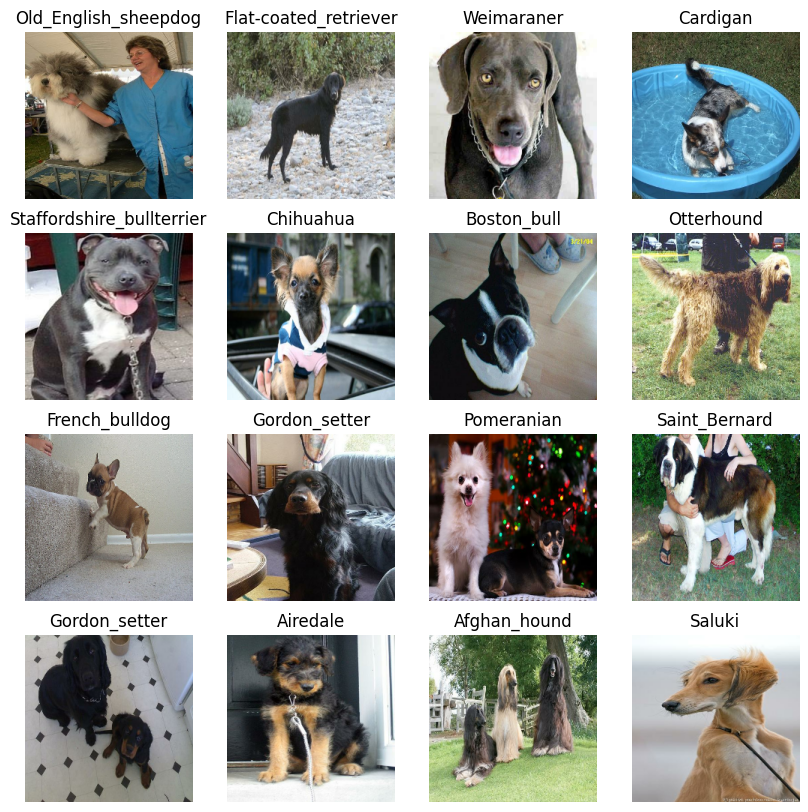

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # берем первый батч обучающей выборки
    for i in range(16): # отрисуем первые 16 картинок батча
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]]) # покажем метки
        plt.axis("off") # отключаем отображение осей

### Аугментация данных

Несмотря, на то, что наш датасет содержит 20570 изображений (с учетом "битых" файлов), но в пересчете на одну категорию получается примерно по 171 изображению на каждую категорию. Это совсем небольшой датасет, и потому хорошей практикой считается проведение аугментации (или расширения данных). Эта процедура нам хорошо знакома из прошлого урока.

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

Мы помним, что аугментацию можно делать как частью модели, которую мы собираем, так и функцией для предварительной обработки данных перед вводом в модель. Использование функции упрощает визуализацию расширенного набора изображений.

Выведем 16 примеров аугментированных изображений:

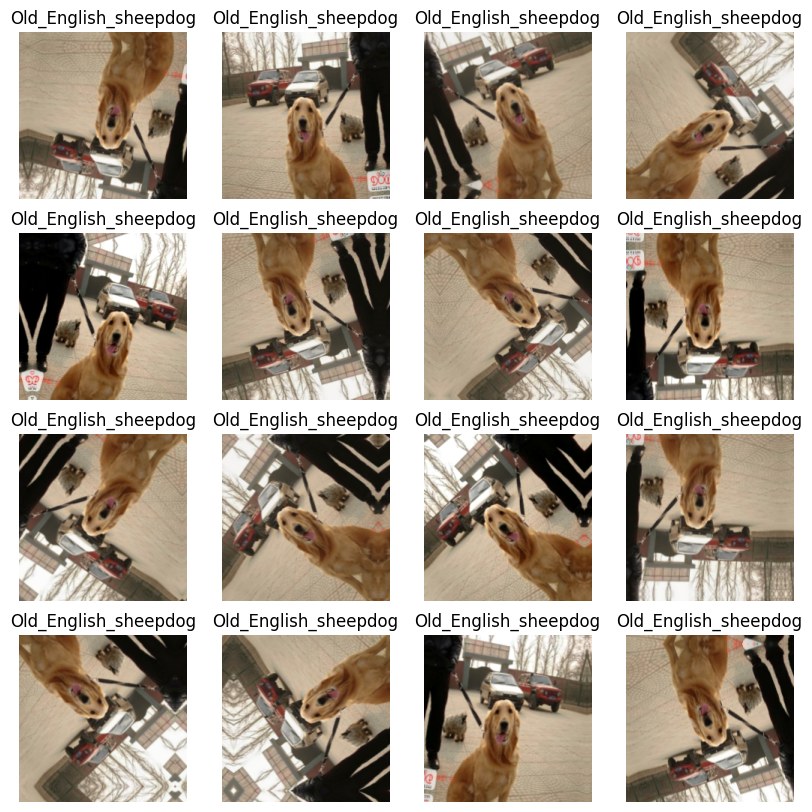

In [ ]:
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[0])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8")) # Преобразуем картинку в тензор, теперь уже без NumPy
        plt.title("{}".format(CLASS_LIST[label[0]])) # Вывод метки
        plt.axis("off")

### Предварительная обработка данных

Как только мы убедимся, что входные данные и аугментация работают правильно, мы подготовим набор данных для обучения. Размер входных данных изменяется до единообразного IMG_SIZE. Метки помещаются в одноразовую (она же категориальная) кодировку. Набор данных сопоставлен.

Примечание: предварительная выборка и автонастройка могут в некоторых ситуациях повысить производительность, но зависит от среды и конкретного используемого набора данных. Смотрите это руководство для получения дополнительной информации о производительности конвейера данных.

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### Вспомогательные функции

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

### Перенос обучения с предварительно обученных весов

Далее мы инициализируем модель с предварительно обученными весами ImageNet и с помощью тонкой настройки (fine-tune) настраиваем ее на нашем собственном наборе данных.

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

Первым шагом для переноса обучения является замораживание всех слоев и обучение только верхних слоев. Для этого шага можно использовать относительно большую скорость обучения (learning rate), даже до `1e-2`. Обратите внимание, что точность на проверочной выборке будут выше (потери ниже), чем на обучающей выборке. Это связано с высокой степенью регуляризации, которая подавляет метрики на этапе обучения.

Если аугментация к данным не применялась, то точность на проверочной выборке сможет достигнуть только порядка 60%. Поэтому если на каждый класс вы имеете менее нескольких тысяч (а в некоторых случаях и десятка тысяч) изображений, то обязательно проводите аугментацию.

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - acc: 0.2922 - loss: 3.8389 - val_acc: 0.7003 - val_loss: 1.0662
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - acc: 0.5003 - loss: 2.0083 - val_acc: 0.7309 - val_loss: 0.8841
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - acc: 0.5560 - loss: 1.6469 - val_acc: 0.7453 - val_loss: 0.8213
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - acc: 0.5658 - loss: 1.5584 - val_acc: 0.7474 - val_loss: 0.8276
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - acc: 0.5815 - loss: 1.4958 - val_acc: 0.7618 - val_loss: 0.7611
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - acc: 0.5921 - loss: 1.4598 - val_acc: 0.7718 - val_loss: 0.7478
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - acc: 0.5931 - loss: 1.4506 - val_acc: 0.7628 - val_loss: 0.7794
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - acc: 0.5984 - loss: 1.4418 - val_acc: 0.7713 - val_loss: 0.76

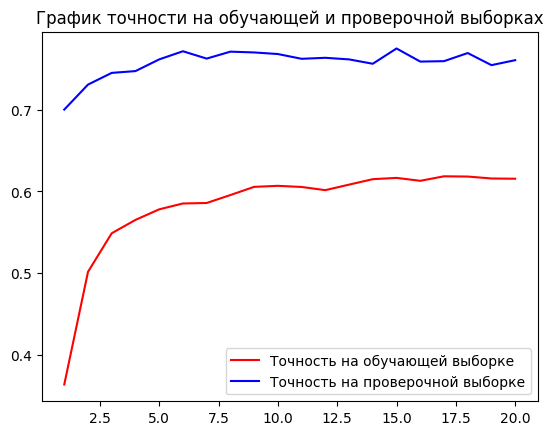

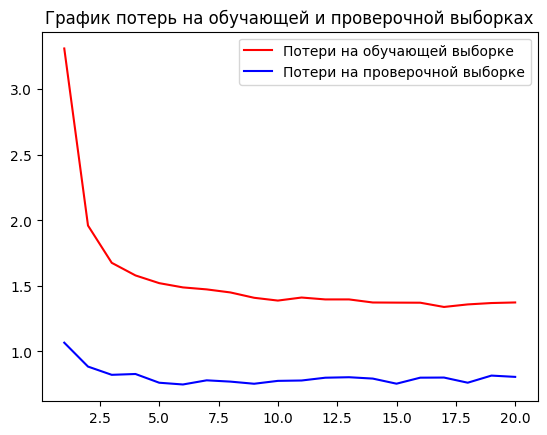

In [ ]:
show_plot(history)

In [ ]:
from google.colab import files
files.download('best_model_pretrain.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Разморозка весов

Второй шаг заключается в разморозке несколько дополнительных слоев и подгонки модели, используя меньшую скорость обучения.

В этом примере мы показываем размораживание всех слоев (кроме нормализации на пакете), но в зависимости от конкретного набора данных может оказаться желательным разморозить только часть слоев.

Если извлечение признаков с помощью предварительно обученной модели работает достаточно хорошо, этот шаг даст очень ограниченный выигрыш в точности проверки. В нашем случае мы видим лишь небольшое улучшение, поскольку предварительное обучение `ImageNet` уже показало модели большое количество собак.

С другой стороны, когда мы используем предварительно подготовленные веса для набора данных, который в большей степени отличается от `ImageNet`, этот шаг тонкой настройки может иметь решающее значение, поскольку средство извлечения объектов также нуждается в значительной корректировке. Такую ситуацию можно продемонстрировать, выбрав вместо этого набор данных `CIFAR-100`, где тонкая настройка повышает точность проверки примерно на 10% и достигает 80% в `EfficientNetB0`.

**ВАЖНОЕ ЗАМЕЧАНИЕ**. Установка `model.trainable` одновременно установит параметр обучаемости для всех слоев, принадлежащих модели, один и тот же атрибут обучаемости. Каждый слой является обучаемым, только если обучаемы как сам слой, так и модель, содержащая его. Следовательно, когда нам нужно частично заморозить/разморозить модель, нам нужно убедиться, что для  `trainable` атрибута модели установлено значение `True`.

Epoch 1/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - acc: 0.6276 - loss: 1.3173 - val_acc: 0.7708 - val_loss: 0.7661
Epoch 2/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - acc: 0.6442 - loss: 1.2462 - val_acc: 0.7776 - val_loss: 0.7419
Epoch 3/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - acc: 0.6485 - loss: 1.2187 - val_acc: 0.7827 - val_loss: 0.7273
Epoch 4/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - acc: 0.6524 - loss: 1.1929 - val_acc: 0.7871 - val_loss: 0.7165


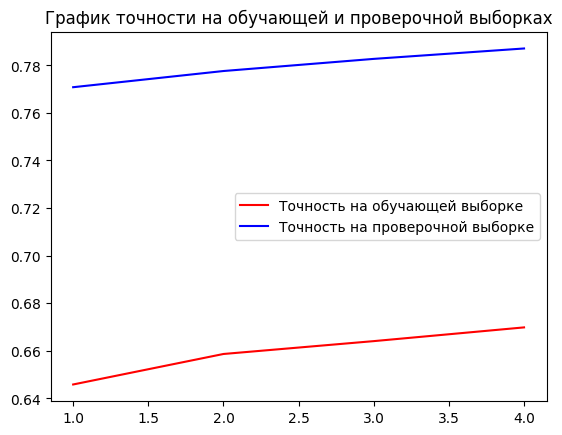

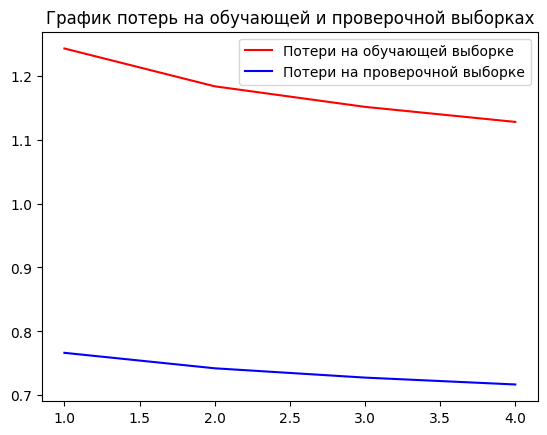

In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

Таким образом, благодаря переносу обучения и тонкой настройки, мы обучили нашу модель предсказывать породу собак с вероятностью почти 79%, что вполне неплохой результат, учитывая, что предсказание идет по 120 породам!

### Проверка модели

Проверим, как работает наша модель. Распознаем картинку, которую "не видела" наша модель.

--2024-02-17 00:56:38--  https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47310 (46K) [image/jpeg]
Saving to: ‘Cardigan.jpeg.12’

Cardigan.jpeg.12    100%[===================>]  46.20K  --.-KB/s    in 0.1s    

2024-02-17 00:56:39 (336 KB/s) - ‘Cardigan.jpeg.12’ saved [47310/47310]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


(-0.5, 223.5, 223.5, -0.5)

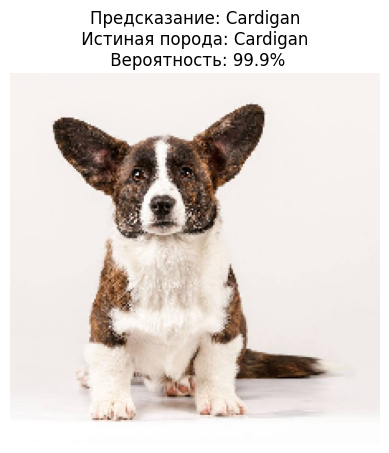

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
TEST_IMG='./Cardigan.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Cardigan \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")



Отлично! Модель уверена на 99,9%, что на картинке изображена Cardigan (разновидность Корги). Так и есть! Подведем итоги.

### Выводы по переносу обучения

**Общие замечания**:
1. Обучение переносу состоит в том, чтобы взять признаки, изученные в рамках одной задачи, и использовать их в новой, аналогичной задаче. Например, признаки модели, которая научилась идентифицировать енотов, могут быть полезны для запуска модели, предназначенной для идентификации тануки (енотовидной собаки).

2. Обучение переносу обычно выполняется для задач, в которых в вашем датасете слишком мало примеров для обучения полномасштабной модели с нуля.

**Наиболее распространенной схемой переноса является следующий рабочий процесс:**

1. Берем слои из ранее обученной модели.
2. Замораживаем их, чтобы избежать уничтожения какой-либо информации, которую они содержат, во время будущих раундов обучения.
3. Добавляем несколько новых, поддающихся обучению слоев поверх замороженных слоев. Они научатся превращать старые объекты в предсказания на новом наборе данных.
4. Тренируем новые слои на вашем наборе данных.
5. Последним необязательным шагом является точная настройка, которая заключается в размораживании всей модели, полученной выше (или ее части), и повторном обучении ее на новых данных с очень низкой скоростью обучения. Это потенциально может привести к значимым улучшениям за счет постепенной адаптации предварительно обученных функций к новым данным.

### Советы по точной настройке EfficientNet

**О разморозке слоев:**

* Все веса являются обучаемыми. Единственный встроенный слой, который имеет необучаемые веса - это слой пакетной нормализации. Он использует необучаемые веса для отслеживания среднего значения и дисперсии своих входных данных во время обучения. Поэтому слои пакетной нормализации (`BatchNormalization`) необходимо сохранять замороженными. Если они будут доступны для обучения, то уже на первой эпохе после разморозки точность значительно снизится.
* В некоторых случаях может оказаться полезным разморозить только часть слоев вместо размораживания всех. Это значительно ускорит тонкую настройку при переходе к более крупным моделям, таким как B7.
* Модель содержит "остаточные блоки" (ResBlock). Каждый блок должен быть полностью включен или выключен. Это связано с тем, что архитектура включает в себя "обходные связи" от первого слоя блока к последнему и так для каждого блока. Несоблюдение требований к блокам также значительно снижает конечную производительность.


**Использование EfficientNet:**

* Увеличенные варианты EfficientNet не гарантируют повышения производительности, особенно для задач с меньшим количеством данных или классов. В таком случае, чем больше выбран вариант EfficientNet, тем сложнее настроить гиперпараметры.
* EMA (экспоненциальное скользящее среднее) очень полезно при обучении EfficientNet с нуля, но не так сильно для обучения переносу.
* Не используйте оптимизатор RMSProp, как в оригинальной статье, для тонкой настройки. Импульс и скорость обучения слишком высоки для тонкой настройки. Это легко повредит предварительно настроенные веса и увеличит потери. Быстрая проверка заключается в том, чтобы увидеть, становятся ли потери (как категориальная перекрестная энтропия) значительно больше, чем `log(CLASS_COUNT)` после той же эпохи. Если это так, начальная скорость обучения / импульс слишком высоки.
* Меньший размер пакета повышает точность на проверочной выборке, возможно, за счет эффективного обеспечения регуляризации. Однако небольшой размер пакета при большом датасете приводит к увеличению потребляемого ОЗУ (оперативной памяти), выход за пределы которой приведет к остановке процесса обучения и экстренной перезагрузки среды выполнения.

В [следующей части урока](https://colab.research.google.com/drive/1ZWfrEDQaQqDmVUF0yk7N4yoMHRkXf9K-) мы познакомимся с KerasCV. Разработчики Keras решили часть функционала по компьютерному зрению вынести в отдельное API и назвали его KerasCV, при этом сохранив полную совместимость с Keras.